In [16]:
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from tqdm import tqdm

In [2]:
path = r'/data2/goesaert/'
fname = 'Abell_85_Linpol_Freqmean'
hdu = fits.open(get_pkg_data_filename(path+fname+'.fits'))[0]
header = hdu.header
data = hdu.data

In [11]:
def create_annulus_mask(h, w, radius_inner, radius_outer, center=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask_loc = (dist_from_center >= radius_inner) & (dist_from_center <= radius_outer)
    return mask_loc

In [13]:
res = 10
rms_edges = np.arange(0, 0.50*np.sqrt(2)*data.shape[1]+res, res)
median_array = np.zeros(len(rms_edges)-1)
rms_array = np.zeros(len(rms_edges)-1)
median_map = np.zeros(np.shape(data))
rms_map = np.zeros(np.shape(data))
std_map = np.zeros(np.shape(data))
mean_map = np.zeros(np.shape(data))

for n in tqdm(range(len(rms_edges)-1)):
    mask = create_annulus_mask(data.shape[1], data.shape[0], radius_inner=rms_edges[n], radius_outer=rms_edges[n+1])
    data_masked_flat = data[mask][~np.isnan(data[mask])]
    
    percentiles = np.percentile(data_masked_flat, [25, 50, 75])
    median_array[n] = percentiles[1]
    rms_array[n] = (percentiles[2] - percentiles[0])/(stats.norm.ppf(0.75) - stats.norm.ppf(0.25))

    median_map[mask] = median_array[n]
    rms_map[mask] = rms_array[n]
    std_map[mask] = np.std(data_masked_flat)
    mean_map[mask] = np.mean(data_masked_flat)

100%|██████████| 256/256 [00:36<00:00,  7.06it/s]


In [14]:
hdu_median = fits.PrimaryHDU(median_map)
hdu_rms = fits.PrimaryHDU(rms_map)
hdu_median.writeto(path+fname+'_circmedianmap.fits', overwrite=True)
hdu_rms.writeto(path+fname+'_circrmsmap.fits', overwrite=True)

#hdu_mean = fits.PrimaryHDU(mean_map)
#hdu_std = fits.PrimaryHDU(std_map)
#hdu_mean.writeto(path+fname+'_circmeanmap.fits', overwrite=True)
#hdu_std.writeto(path+fname+'_circstdmap.fits', overwrite=True)

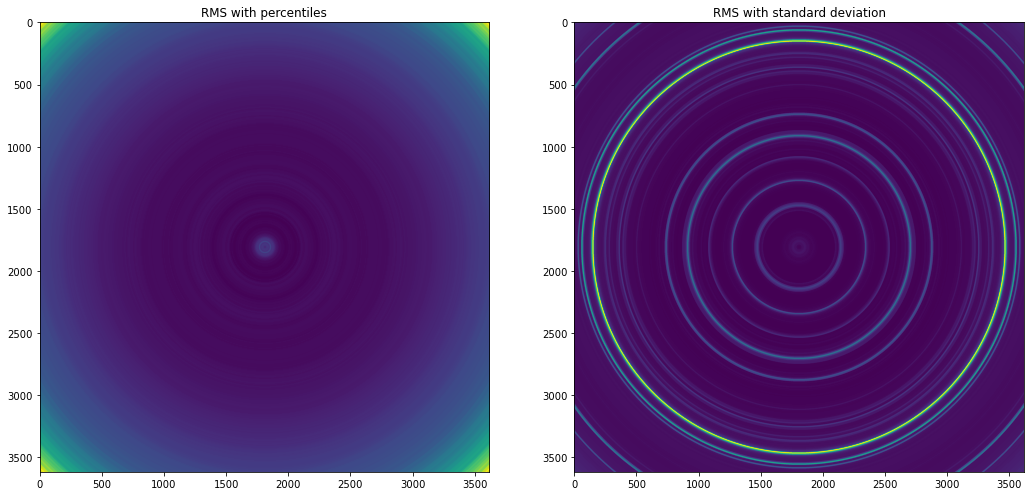

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))  # 1 row, 2 columns
ax1.imshow(rms_map)
ax1.set_title('RMS with percentiles')
ax2.imshow(std_map)
ax2.set_title('RMS with standard deviation')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(0.5*(rms_edges[:-1]+rms_edges[1:]), rms_array)
plt.show()